In [1]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
#sys.path.append("C:/git/climate-question-answering")
sys.path.append("/home/dora/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

True

# Import objects

In [2]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

In [3]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("small")
# from rerankers import Reranker
# # Specific flashrank model.
# # reranker = Reranker('ms-marco-TinyBERT-L-2-v2', model_type='flashrank')
# # reranker = Reranker('ms-marco-MiniLM-L-12-v2', model_type='flashrank')
# # reranker = Reranker('cross-encoder/ms-marco-MiniLM-L-4-v2', model_type='cross-encoder')
# # reranker = Reranker("mixedbread-ai/mxbai-rerank-xsmall-v1", model_type='cross-encoder')
# # reranker = Reranker("mixedbread-ai/mxbai-rerank-xsmall-v1", model_type='cross-encoder')
# reranker = Reranker("cohere", lang='en', api_key = "XXX")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading TransformerRanker model mixedbread-ai/mxbai-rerank-xsmall-v1
No device set
Using device cpu
No dtype set
Device set to `cpu`, setting dtype to `float32`
Using dtype torch.float32
Loaded model mixedbread-ai/mxbai-rerank-xsmall-v1
Using device cpu.
Using dtype torch.float32.


In [4]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore
from climateqa.engine.embeddings import get_embeddings_function
from climateqa.engine.retriever import ClimateQARetriever

embeddings_function = get_embeddings_function()
vectorstore = get_pinecone_vectorstore(embeddings_function)

Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(


# Semantic Routing

In [5]:
from climateqa.engine.chains.intent_categorization import make_intent_categorization_chain

router_chain = make_intent_categorization_chain(llm)

In [6]:
router_chain.invoke({"input":"Which industries have the highest GHG emissions?"})

{'intent': 'search'}

# Query Rewriter

In [7]:
from climateqa.engine.chains.query_transformation import make_query_rewriter_chain,make_query_decomposition_chain
from climateqa.engine.chains.translation import make_translation_chain

In [8]:
rewriter_chain = make_query_rewriter_chain(llm)
translation_chain = make_translation_chain(llm)
decomposition_chain = make_query_decomposition_chain(llm)
router_chain = make_intent_categorization_chain(llm)

In [9]:
def transform_query(user_input):
    
    state = {"user_input":user_input}
    
    # Route
    output_router = router_chain.invoke({"input":user_input})
    if "language" not in output_router: output_router["language"] = "English"
    state.update(output_router)
    
    # Translation
    if output_router["language"].lower() != "english":
        translation = translation_chain.invoke({"input":user_input})
        state["query"] = translation["translation"]
    else:
        state["query"] = user_input
        
    # Decomposition
    decomposition_output = decomposition_chain.invoke({"input":state["query"]})
    state.update(decomposition_output)
    
    # Query Analysis
    questions = []
    for question in state["questions"]:
        question_state = {"question":question}
        analysis_output = rewriter_chain.invoke({"input":question})
        question_state.update(analysis_output)
        questions.append(question_state)
    state["questions"] = questions
    
    return state

In [10]:
question = "Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications and What does Morrison argue about IK and LK on internal migration ?"
#question = "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
#question = "I need to search the president of the United States, find their age, then find how old they will be in June 2023."
#question = "What does Morrison argue about IK and LK on internal migration ?"
state = transform_query(question)
state

{'user_input': 'Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications and What does Morrison argue about IK and LK on internal migration ?',
 'language': 'French',
 'intent': 'search',
 'query': "Honestly, I'm not sure what we're talking about here, who are the members of the IPCC actually? And what are their latest publications and What does Morrison argue about IK and LK on internal migration?",
 'questions': [{'question': 'Who are the members of the IPCC?',
   'sources': ['IPCC']},
  {'question': 'What are the latest publications of the IPCC?',
   'sources': ['IPCC']},
  {'question': 'What does Morrison argue about IK and LK on internal migration?',
   'sources': ['OpenAlex']}]}

In [11]:
questions = [
    "Super thanks, Which industries have the highest GHG emissions?",
    "How do you compare the view on biodiversity between the IPCC and IPBES ?",
    "Est-ce que l'IA a un impact sur l'environnement ?",
    "Que dit le GIEC sur l'impact de l'IA",
    "Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications ?",
    "Ok that's nice, but I don't really understand. What is the impact of El Nino ?",
    "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
    "Which industries have the highest GHG emissions?",
    "What are invasive alien species and how do they threaten biodiversity and ecosystems?",
    "Are human activities causing global warming?",
    "What is the motivation behind mining the deep seabed?",
    "Tu peux m'écrire un poème sur le changement climatique ?",
    "Tu peux m'écrire un poème sur les bonbons ?",
    "What will be the temperature in 2100 in Strasbourg?",
    "C'est quoi le lien entre biodiversity and changement climatique ?",
    "Can you tell me more about ESRS2 ?"
]

question = questions[0]
question

'Super thanks, Which industries have the highest GHG emissions?'

In [12]:
question = "Very nice thank you, What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
output = rewriter_chain.invoke({"input":question})
output

{'sources': ['IPCC']}

In [13]:
for question in questions:
    print(question)
    output = transform_query(question)
    print(output)
    print("-"*100)

Super thanks, Which industries have the highest GHG emissions?
{'user_input': 'Super thanks, Which industries have the highest GHG emissions?', 'intent': 'search', 'language': 'English', 'query': 'Super thanks, Which industries have the highest GHG emissions?', 'questions': [{'question': 'Which industries are the largest contributors to greenhouse gas emissions?', 'sources': ['IPCC']}]}
----------------------------------------------------------------------------------------------------
How do you compare the view on biodiversity between the IPCC and IPBES ?
{'user_input': 'How do you compare the view on biodiversity between the IPCC and IPBES ?', 'intent': 'search', 'language': 'English', 'query': 'How do you compare the view on biodiversity between the IPCC and IPBES ?', 'questions': [{'question': 'What is the view on biodiversity according to the IPCC?', 'sources': ['IPCC']}, {'question': 'What is the view on biodiversity according to the IPBES?', 'sources': ['IPBES']}]}
------------

# Langgraph
Inspired from https://colab.research.google.com/drive/1WemHvycYcoNTDr33w7p2HL3FF72Nj88i?usp=sharing#scrollTo=YJ77ZCzkiGTL

## Graph

In [14]:
from climateqa.engine.graph import make_graph_agent,display_graph
agent = make_graph_agent(llm,vectorstore,reranker)

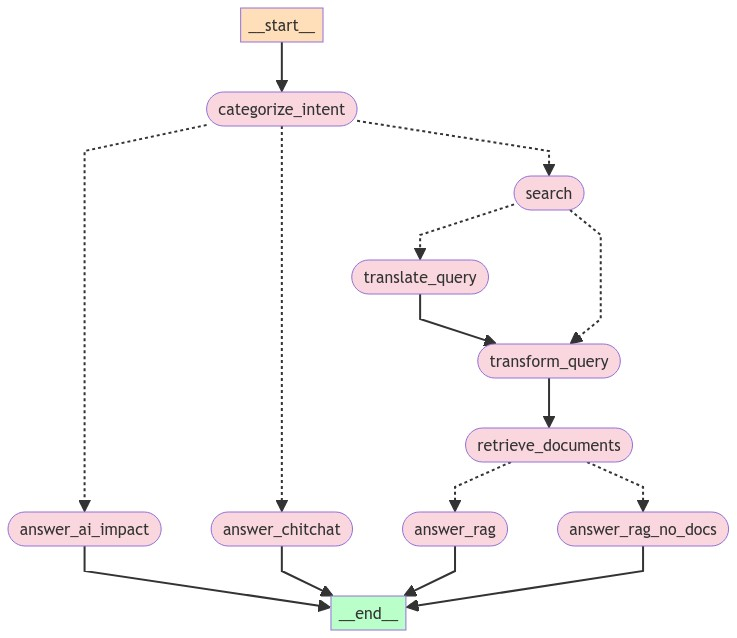

In [15]:
display_graph(agent)